In [11]:
import csv
import numpy as np
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import pickle

In [12]:
DS = pd.read_csv("DataAnnotatedSubset150SentenceLength.csv")

In [13]:
DS.head()

,text_ID,word,tag
0,46809,RR,object
1,46809,130/80,value
2,46809,mmHg.,NaN
3,47482,"RR142/89mmHg,",object
4,47482,HR,NaN


In [14]:
DS['tag'].fillna('unk', inplace=True)

In [15]:
words = list(set(DS["word"].values))
n_words = len(words)
n_words

27741

In [16]:
tags = list(set(DS["tag"].values))
n_tags = len(tags); n_tags


3

In [17]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                           s["tag"].values.tolist())]
        self.grouped = self.data.groupby("text_ID").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [18]:
getter = SentenceGetter(DS)

In [19]:
sentences =[" ".join([s[0] for s in sent]) for sent in getter.sentences]


In [20]:
sentences[1]

'Pt. tehtud 3 plasmaferees, talus hästi. Eemaldatud 700 ml plasmat. RR 112/60 mmHg. Tgasi 22.10.09.'

In [21]:
labels = [[s[1] for s in sent] for sent in getter.sentences]
print(labels[0])


['unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk', 'object', 'value', 'unk', 'unk', 'unk', 'unk', 'unk', 'unk']


In [22]:
tags_vals = list(set(DS["tag"].values))
tag2idx = {t: i for i, t in enumerate(tags_vals)}


In [77]:
tag2idx

{'unk': 0, 'object': 1, 'value': 2}

In [5]:
import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

In [7]:
MAX_LEN = 75
bs = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()


In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')


The pre-trained model you are loading is a cased model but you have not set `do_lower_case` to False. We are setting `do_lower_case=False` for you but you may want to check this behavior.
100%|██████████| 995526/995526 [00:01<00:00, 952753.12B/s]


In [23]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print(tokenized_texts[0])

['26', '.', '05', '.', '09', 'pats', '##ient', 'hospital', '##ise', '##eritud', 'er', '##üt', '##rots', '##ü', '##üt', '##ide', 'üle', '##kan', '##dek', '##s', ',', '2', 'do', '##osi', 'RR', '120', '/', '85', 'temperatuur', '37', '.', '7', '.', 'V', '##õe', '##tud', 'vere', '##ana', '##lü', '##üs', '##id', '.', 'En', '##ese', '##tun', '##ne', 'ra', '##huld', '##av', '.']


In [24]:
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (530 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (533 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (520 > 512). Running this sequence through BERT will result in indexing errors
Token indices sequence length is longer than the specified maximum  sequence length for this BERT model (560 > 512). Running this sequence through BERT will result in indexing errors


In [28]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["unk"], padding="post",
                     dtype="long", truncating="post")


In [47]:
tag2idx

{'unk': 0, 'object': 1, 'value': 2}

In [53]:
print(input_ids[1])

[56445   119 63164 16107   124 49288 50544 10171   117 13675 10251   176
 57747   119   142 18089 23388 16107 12367 58240 49288 10123   119 80993
 16129   120 10709 10366 12396 10240   119   157 90612 10306   119 10150
   119 11035   119     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]


#the mask to ignore the padded elements in the sequences.

In [29]:
attention_masks = [[float(i>0) for i in ii] for ii in input_ids]


In [51]:
print(attention_masks[1])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [30]:
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags, 
                                                            random_state=2018, test_size=0.1)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)


#### Since we’re operating in pytorch, we have to convert the dataset to torch tensors.



In [57]:
tr_inputs = torch.tensor(tr_inputs).to(torch.int64)
val_inputs = torch.tensor(val_inputs).to(torch.int64)
tr_tags = torch.tensor(tr_tags).to(torch.int64)
val_tags = torch.tensor(val_tags).to(torch.int64)
tr_masks = torch.tensor(tr_masks).to(torch.int64)
val_masks = torch.tensor(val_masks).to(torch.int64)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Kasutaja\Anaconda3\env

In [58]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)


In [42]:
model = BertForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(tag2idx))

In [ ]:
# model.cuda();

In [59]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = Adam(optimizer_grouped_parameters, lr=3e-5)


In [60]:
from seqeval.metrics import f1_score

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=2).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


In [61]:
epochs = 5
max_grad_norm = 1.0

for _ in trange(epochs, desc="Epoch"):
    # TRAIN loop
    model.train()
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # forward pass
        loss = model(b_input_ids, token_type_ids=None,
                     attention_mask=b_input_mask, labels=b_labels)
        # backward pass
        loss.backward()
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        model.zero_grad()
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
    # VALIDATION on validation set
    model.eval()
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                                  attention_mask=b_input_mask, labels=b_labels)
            logits = model(b_input_ids, token_type_ids=None,
                           attention_mask=b_input_mask)
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.append(label_ids)
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        eval_loss += tmp_eval_loss.mean().item()
        eval_accuracy += tmp_eval_accuracy
        
        nb_eval_examples += b_input_ids.size(0)
        nb_eval_steps += 1
    eval_loss = eval_loss/nb_eval_steps
    print("Validation loss: {}".format(eval_loss))
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
    pred_tags = [tags_vals[p_i] for p in predictions for p_i in p]
    valid_tags = [tags_vals[l_ii] for l in true_labels for l_i in l for l_ii in l_i]
    print("F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.10193984228923607
Validation loss: 0.0823858518933141
Validation Accuracy: 0.955373292727944


Epoch:  20%|██        | 1/5 [1:47:48<7:11:12, 6468.10s/it]

F1-Score: 0.22283272283272285
Train loss: 0.0648018626573806
Validation loss: 0.07302507641183775
Validation Accuracy: 0.964882336655592


Epoch:  40%|████      | 2/5 [3:32:16<5:20:24, 6408.27s/it]

F1-Score: 0.2547386559448593
Train loss: 0.05549227288186861
Validation loss: 0.05696586536806683
Validation Accuracy: 0.9615439276485791


Epoch:  60%|██████    | 3/5 [5:16:13<3:31:53, 6356.69s/it]

F1-Score: 0.29755835792862895
Train loss: 0.04849204848869704
Validation loss: 0.06190077107139798
Validation Accuracy: 0.9587278516057584


Epoch:  80%|████████  | 4/5 [7:00:17<1:45:23, 6323.05s/it]

F1-Score: 0.2737290257951415
Train loss: 0.04339630737619397
Validation loss: 0.0593537884915984
Validation Accuracy: 0.9576970284237725


Epoch: 100%|██████████| 5/5 [8:44:13<00:00, 6290.66s/it]  

F1-Score: 0.27697145621673924


In [62]:
model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

Validation loss: 0.0593537884915984
Validation Accuracy: 0.9576970284237725
Validation F1-Score: 0.4000379362670713


In [118]:
i = 10
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(tokenizer.convert_ids_to_tokens(input_ids[i]), pred_tags[i], valid_tags[i]):
    if w != 0:
        print("{:15}: {:5} {}".format(w, t, pred))


Word           ||True ||Pred
Ko             : object object
##kku          : value value
##v            : unk   unk
##õ            : unk   unk
##te           : unk   unk
:              : unk   unk
SK             : unk   unk
##G            : unk   unk
vale           : unk   unk
##m            : unk   unk
:              : unk   unk
1              : unk   unk
##D            : object unk
A              : unk   unk
(              : unk   object
211            : unk   unk
)              : unk   unk
C              : unk   unk
(              : unk   unk
31             : unk   unk
)              : unk   unk
OM             : unk   unk
(              : unk   unk
2              : unk   unk
)              : unk   unk
D              : unk   unk
(              : unk   unk
201            : unk   unk
)              : unk   unk
PT             : unk   unk
##CA           : unk   unk
+              : unk   unk
BM             : unk   unk
##S            : unk   unk
C              : unk   unk
(              :

['Pt',
 '.',
 'teh',
 '##tud',
 '3',
 'plasma',
 '##fere',
 '##es',
 ',',
 'tal',
 '##us',
 'h',
 '##ästi',
 '.',
 'E',
 '##ema',
 '##lda',
 '##tud',
 '700',
 'ml',
 'plasma',
 '##t',
 '.',
 'RR',
 '112',
 '/',
 '60',
 'mm',
 '##H',
 '##g',
 '.',
 'T',
 '##gasi',
 '22',
 '.',
 '10',
 '.',
 '09',
 '.',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

In [110]:
max_len = 54
max_len_char = 10

In [111]:
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [112]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in sentences]


In [113]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["PAD"], padding='post', truncating='post')

In [114]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)


104


In [115]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [116]:
X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

In [131]:
y = [[tag2idx[w[1]] for w in s] for s in sentences]


In [132]:
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["PAD"], padding='post', truncating='post')


In [134]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)


In [135]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model = Model([word_in, char_in], out)




In [137]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 54, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 54, 10, 10)   1060        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 54, 20)       554860      input_1[0][0]                    
____________________________________________________________________________________________

In [138]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=10, validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11050 samples, validate on 1228 samples
Epoch 1/10
11050/11050 [==============================] - 56s 5ms/step - loss: 0.0627 - acc: 0.9314 - val_loss: 0.0127 - val_acc: 0.9850
Epoch 2/10
11050/11050 [==============================] - 51s 5ms/step - loss: 0.0096 - acc: 0.9889 - val_loss: 0.0060 - val_acc: 0.9919
Epoch 3/10
11050/11050 [==============================] - 49s 4ms/step - loss: 0.0048 - acc: 0.9942 - val_loss: 0.0049 - val_acc: 0.9939
Epoch 4/10
11050/11050 [==============================] - 51s 5ms/step - loss: 0.0024 - acc: 0.9968 - val_loss: 0.0046 - val_acc: 0.9939
Epoch 5/10
11050/11050 [==============================] - 50s 5ms/step - loss: 0.0014 - acc: 0.9981 - val_loss: 0.0046 - val_acc: 0.9939
Epoch 6/10
11050/11050 [==============================] - 51s 5ms/step - loss: 0.0011 - acc: 0.9986 - val_loss: 0.0048 - val_acc: 0.9933
Epoch 7/10
11050/11050 [==============================] - 51s 5ms/step - loss: 8.4861e-04 - acc: 0.9989 - val_loss: 0.0046 - val_

In [139]:
hist = pd.DataFrame(history.history)


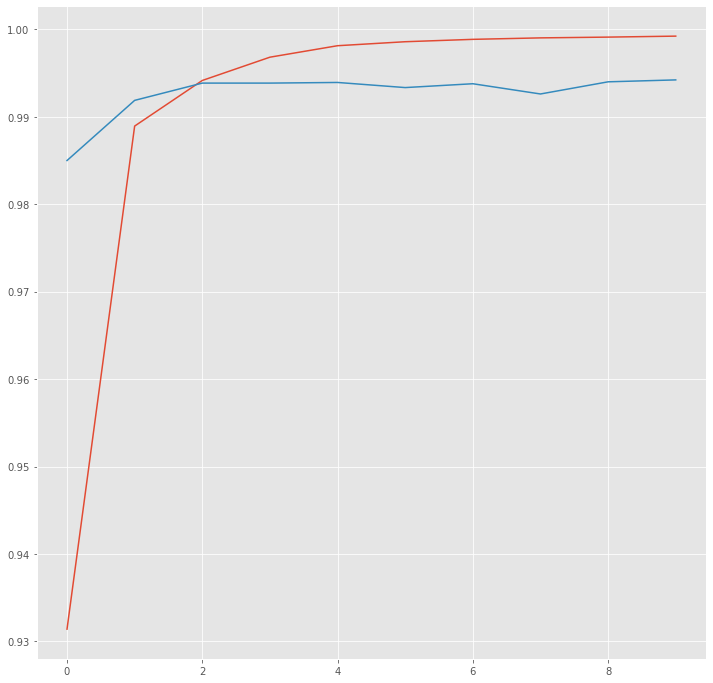

In [140]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()


In [141]:
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])


In [147]:
i = 4
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))


Word           ||True ||Pred
Kardiovaskulaarsüsteem:: unk   unk
RR             : object object
160/100mmHg.   : value value
Ausk-l         : unk   unk
s-toonid       : unk   unk
reg,           : unk   unk
puhtad,        : unk   unk
fr.            : unk   unk
60*min.        : unk   unk
Kardiovaskulaarsüsteem:: unk   unk
RR             : object object
160/100mmHg.   : value value
Ausk-l         : unk   unk
s-toonid       : unk   unk
reg,           : unk   unk
puhtad,        : unk   unk
fr.            : unk   unk
60*min.        : unk   unk


In [185]:


def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p, axis=-1)
            out_i.append(idx2tag[p_i])
        out.append(out_i)
    return out
pred_labels = pred2label(y_pred)

def pred2labelV2(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p])
        out.append(out_i)
    return out
test_labels = pred2labelV2(y_te)

In [199]:
print(test_labels[1])

['unk', 'unk', 'unk', 'unk', 'unk', 'object', 'value', 'unk', 'unk', 'unk', 'unk', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


In [187]:
print(idx2tag[3])
print(y_te[1])

unk
[3 3 3 3 3 2 1 3 3 3 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [188]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))

F1-score: 54.6%


In [189]:
from  sklearn_crfsuite.metrics import flat_classification_report  
report = flat_classification_report(y_pred=pred_labels, y_true=test_labels)
print(report)

              precision    recall  f1-score   support

         PAD       0.00      0.00      0.00     58220
      object       0.33      0.97      0.50      1050
         unk       0.21      1.00      0.34     13658
       value       0.18      0.97      0.30       782

    accuracy                           0.21     73710
   macro avg       0.18      0.73      0.28     73710
weighted avg       0.04      0.21      0.07     73710



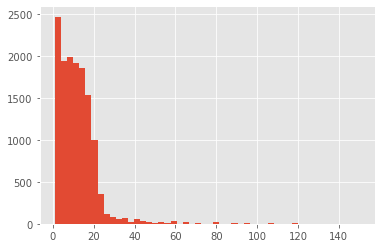

In [205]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [246]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=20, validation_split=0.1, verbose=1)


Train on 11050 samples, validate on 1228 samples
Epoch 1/20
11050/11050 [==============================] - 50s 4ms/step - loss: 5.5176e-04 - acc: 0.9992 - val_loss: 0.0052 - val_acc: 0.9920
Epoch 2/20
11050/11050 [==============================] - 49s 4ms/step - loss: 5.0278e-04 - acc: 0.9994 - val_loss: 0.0051 - val_acc: 0.9933
Epoch 3/20
11050/11050 [==============================] - 49s 4ms/step - loss: 4.4895e-04 - acc: 0.9995 - val_loss: 0.0048 - val_acc: 0.9945
Epoch 4/20
11050/11050 [==============================] - 48s 4ms/step - loss: 4.5015e-04 - acc: 0.9994 - val_loss: 0.0051 - val_acc: 0.9931
Epoch 5/20
11050/11050 [==============================] - 49s 4ms/step - loss: 4.4827e-04 - acc: 0.9993 - val_loss: 0.0050 - val_acc: 0.9944
Epoch 6/20
11050/11050 [==============================] - 48s 4ms/step - loss: 3.7821e-04 - acc: 0.9995 - val_loss: 0.0054 - val_acc: 0.9922
Epoch 7/20
11050/11050 [==============================] - 48s 4ms/step - loss: 3.5568e-04 - acc: 0.9995 -

In [251]:
hist

,val_loss,val_acc,loss,acc
0,0.005189,0.991951,0.000552,0.999216
1,0.005057,0.993268,0.000503,0.999360
2,0.004751,0.994512,0.000449,0.999480
3,0.005068,0.993122,0.000450,0.999408
4,0.005039,0.994366,0.000448,0.999344
5,0.005415,0.992244,0.000378,0.999544
6,0.005571,0.993122,0.000356,0.999456
7,0.005711,0.993048,0.000323,0.999496
8,0.005446,0.992463,0.000346,0.999552
9,0.005533,0.993341,0.000284,0.999656


In [247]:
hist = pd.DataFrame(history.history)


In [ ]:
y_pred2 = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
p2 = np.argmax(y_pred2[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")

In [287]:
i=2
for w, t, pred in zip(X_word_te[i], y_te[i], p2):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))





Kardiovaskulaarsüsteem:: unk   unk
RR             : object object
105/70         : value value
mmHg           : unk   unk


In [249]:

pred_labels2 = pred2label(y_pred2)
test_labels2 = pred2labelV2(y_te)

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
print("F1-score: {:.1%}".format(f1_score(test_labels2, pred_labels2)))



F1-score: 54.6%


In [252]:

from  sklearn_crfsuite.metrics import flat_classification_report  
report2 = flat_classification_report(y_pred=pred_labels2, y_true=test_labels2)
print(report2)




              precision    recall  f1-score   support

         PAD       0.00      0.00      0.00     58220
      object       0.48      0.97      0.64      1050
         unk       0.21      1.00      0.34     13658
       value       0.15      0.98      0.26       782

    accuracy                           0.21     73710
   macro avg       0.21      0.74      0.31     73710
weighted avg       0.05      0.21      0.07     73710



In [308]:
int(2/3 * (max_len * max_len_char))

360

In [309]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D


# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=50,
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=50, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.4)(x)
main_lstm = Bidirectional(LSTM(units=360, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="softmax"))(main_lstm)

model2 = Model([word_in, char_in], out)


model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model2.summary()


Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 54, 10)       0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 54)           0                                            
__________________________________________________________________________________________________
time_distributed_7 (TimeDistrib (None, 54, 10, 10)   1060        input_6[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 54, 50)       1387150     input_5[0][0]                    
____________________________________________________________________________________________

In [ ]:
history2 = model2.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=20, validation_split=0.1, verbose=1)


C:\Users\Kasutaja\Anaconda3\envs\myEnv\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11050 samples, validate on 1228 samples
Epoch 1/20
11050/11050 [==============================] - 202s 18ms/step - loss: 0.0383 - acc: 0.9575 - val_loss: 0.0064 - val_acc: 0.9911
Epoch 2/20
11050/11050 [==============================] - 212s 19ms/step - loss: 0.0050 - acc: 0.9937 - val_loss: 0.0038 - val_acc: 0.9943
Epoch 3/20
11050/11050 [==============================] - 214s 19ms/step - loss: 0.0024 - acc: 0.9968 - val_loss: 0.0037 - val_acc: 0.9947
Epoch 4/20
11050/11050 [==============================] - 210s 19ms/step - loss: 0.0014 - acc: 0.9983 - val_loss: 0.0037 - val_acc: 0.9955
Epoch 5/20
11050/11050 [==============================] - 213s 19ms/step - loss: 9.0499e-04 - acc: 0.9987 - val_loss: 0.0044 - val_acc: 0.9935
Epoch 6/20
11050/11050 [==============================] - 214s 19ms/step - loss: 7.3151e-04 - acc: 0.9991 - val_loss: 0.0039 - val_acc: 0.9952
Epoch 7/20
11050/11050 [==============================] - 211s 19ms/step - loss: 6.5961e-04 - acc: 0.9992 - v

In [296]:
y_pred3 = model2.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
p3 = np.argmax(y_pred3[i], axis=-1)


In [307]:
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
i=103
for w, t, pred in zip(X_word_te[i], y_te[i], p3):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))



Word           ||True ||Pred
04.12.2012     : unk   unk
-              : unk   unk
RR             : object unk
180/80         : value unk
mmHg,          : unk   unk
fr.            : unk   object
87             : unk   value
x`,            : unk   unk
O2             : unk   unk
saturatsioon   : unk   unk
98%,           : unk   unk
kaal           : unk   unk
60             : unk   unk
kg.            : unk   unk
pikkus         : unk   unk
1.50           : unk   unk
cm.            : unk   unk
.              : unk   unk


In [298]:
pred_labels3 = pred2label(y_pred3)
test_labels3 = pred2labelV2(y_te)
print("F1-score: {:.1%}".format(f1_score(test_labels3, pred_labels3)))


F1-score: 54.4%


In [299]:
report3 = flat_classification_report(y_pred=pred_labels3, y_true=test_labels3)
print(report3)



              precision    recall  f1-score   support

         PAD       0.00      0.00      0.00     58220
      object       0.29      0.98      0.45      1050
         unk       0.21      1.00      0.34     13658
       value       0.20      0.97      0.33       782

    accuracy                           0.21     73710
   macro avg       0.17      0.74      0.28     73710
weighted avg       0.04      0.21      0.07     73710



In [206]:
test_sentence = " Tupp vaba, em.kael puhas, RR 155/85 mmhg , emakas vÃ¤ike, adn.ii."
test_sentence = ''.join(test_sentence).split() 


In [208]:
x_test_sent = pad_sequences(sequences=[[word2idx.get(w, 0) for w in test_sentence]],
                            padding="post", value=0, maxlen=max_len)


In [253]:
# y_pred = model.predict(x_test_sent,X_char_mytest)

# p = model.predict(x_test_sent)
# p = np.argmax(p, axis=-1)

# print("{:15}||{}".format("Word", "Prediction"))
# print(30 * "=")
# for w, pred in zip(test_sentence, p[0]):
#     print("{:15}: {:5}".format(w, tags[pred]))
